# Exploratory Text Analysis for Dickens' Works

## 1. Import original text file and divide by chapters

A script "chapter_splitter.py" is used to divide the original text files into chapters with filename in the following form : bookName_chapterNum.txt

## 2. Convert corpus to F2 form and store as .db file

In [1]:
import corpus_importer as ci
import make_db as md
import vsm_stage as vs

[nltk_data] Downloading package punkt to /Users/hanyuli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hanyuli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hanyuli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/hanyuli/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hanyuli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hanyuli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hanyuli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to

In [2]:
src_dir = "../chappertest/corpus"
db_file = "corpus1.db"

### Use function in "corpus_importer" to convert corpus

The function will give us tokens and vocabs from imported corpus. Due to the size of corpus, this might take a little while.

In [3]:
ci.import_corpus(src_dir, db_file)

### Add F4 attributes

Calculate TF, TFIDF, THM, TFTH, etc, from tokens and vocabs, and save the new SQLite file.

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import textman as tx

In [5]:
db_name = db_file
    
OHCO = ['book','chapter', 'para_num', 'sent_num', 'token_num']

with sqlite3.connect(db_name) as db:
    K = pd.read_sql('SELECT * FROM token', db, index_col=OHCO)
    V = pd.read_sql('SELECT * FROM vocab', db, index_col='term_id')

WORDS = (K.punc == 0) & (K.num == 0) & K.term_id.isin(V[V.stop==0].index)
BOW = K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()
DTM = BOW.unstack().fillna(0)

# compute TF
alpha = .000001
alpha_sum = alpha * V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

# compute TFIDF
N_docs = DTM.shape[0]
V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / V[V.stop==0]['df'])

# compute TFTH
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

# add stats to V
V['tf_sum'] = TF.sum()
V['tf_mean'] = TF.mean()
V['tf_max'] = TF.max()
V['tfidf_sum'] = TFIDF.sum()
V['tfidf_mean'] = TFIDF.mean()
V['tfidf_max'] = TFIDF.max()
V['tfth_sum'] = TFTH.sum()
V['tfth_mean'] = TFTH.mean()
V['tfth_max'] = TFTH.max()
V['th_sum'] = THM.sum()
V['th_mean'] = THM.mean()
V['th_max'] = THM.max()

D = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

# get all goc pairs
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]
P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
P.index.names = ['doc_x','doc_y']

def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

P['euclidean'] = 0
P['euclidean'] = P.apply(euclidean, 1)

def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt((D1**2).sum())
    b = np.sqrt((D2**2).sum())
    c = a * b
    z = y / c
    return z

P['cosine'] = P.apply(cosine, 1)

### Show some results

In [32]:
K.sample(5)

,,,,,pos,token_str,punc,num,term_str,term_id
book,chapter,para_num,sent_num,token_num,,,,,,
Little-Dorrit,63,62,1,11,DT,this,0,0,this,32916
Bleak-House,32,80,1,0,NN,Yes.,0,0,yes,37430
Great-Expectations,54,71,2,0,PRP,He,0,0,he,15318
Dombey-and-Son,59,80,1,21,DT,a,0,0,a,0
David-Copperfield,13,61,0,26,WRB,where,0,0,where,36607


In [9]:
V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
0,a,84804,2.218943e-02,a,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aaron,14,3.663176e-06,aaron,0,1.0,0.000098,5.766549e-06,0.000098,0.000401,0.000024,0.000401,1.279733e-07,7.527839e-09,1.279728e-07,0.001305,0.000077,0.001305
2,aback,16,4.186487e-06,aback,0,8.0,0.000123,7.251995e-06,0.000044,0.000134,0.000008,0.000048,2.373918e-07,1.396422e-08,8.538625e-08,0.001926,0.000113,0.000641
3,abaft,1,2.616554e-07,abaft,0,1.0,0.000006,3.726552e-07,0.000006,0.000026,0.000002,0.000026,6.930849e-10,4.076970e-11,6.930448e-10,0.000109,0.000006,0.000109
4,abandon,33,8.634630e-06,abandon,0,11.0,0.000247,1.450132e-05,0.000041,0.000155,0.000009,0.000026,9.282723e-07,5.460425e-08,1.541297e-07,0.003765,0.000221,0.000597


In [10]:
D.head()

,term_count,tf
book,,
A-Christmas-Carol,11614,0.006938
A-Tale-of-Two-Cities,55347,0.033062
Barnaby-Rudge,109785,0.065582
Bleak-House,150896,0.090140
David-Copperfield,146583,0.087563


In [31]:
D.index.values

array(['A-Christmas-Carol', 'A-Tale-of-Two-Cities', 'Barnaby-Rudge',
       'Bleak-House', 'David-Copperfield', 'Dombey-and-Son',
       'Great-Expectations', 'Hard-Times', 'Little-Dorrit',
       'Martin-Chuzzlewit', 'Master-Humphreys-Clock', 'Nicholas-Nickleby',
       'Oliver-Twist', 'Our-Mutual-Friend', 'The-Chimes',
       'The-Old-Curiosity-Shop', 'The-Pickwick-Papers'], dtype=object)

In [11]:
P.head()

euclidean    cosine
doc_x             doc_y                                    
A-Christmas-Carol A-Tale-of-Two-Cities   0.109405  0.000466
                  Barnaby-Rudge          0.106219  0.000836
                  Bleak-House            0.105744  0.000599
                  David-Copperfield      0.109979  0.000620
                  Dombey-and-Son         0.114684  0.000442

### Find significant words

In [12]:
TOPS = pd.DataFrame(index=range(10))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = V.sort_values(key, ascending=False).term_str.head(10).tolist()

TOPS.head()

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,said,mr,scrooge,scrooge,said,mr,said,mr
1,mr,scrooge,pickwick,nicholas,mr,said,mr,scrooge
2,little,said,nicholas,pickwick,little,little,little,said
3,man,pickwick,bounderby,bounderby,man,sir,man,pickwick
4,old,trotty,dombey,dombey,old,old,old,trotty


### Save the SQLite file

In [13]:
db_name = db_file

with sqlite3.connect(db_name) as db:
        V.to_sql('vocab', db, if_exists='replace', index=True)
        K.to_sql('token', db, if_exists='replace', index=True)
        D.to_sql('doc', db, if_exists='replace', index=True)
        P.to_sql('docpair', db, if_exists='replace', index=True)
#     BOW.to_frame().rename(columns={'term_id':'n'}).to_sql('bow', db, if_exists='replace', index=True)
        TFIDF.stack().to_frame().rename(columns={0:'term_weight'})\
            .to_sql('dtm_tfidf', db, if_exists='replace', index=True)

## 3. Move to F5

In [14]:
import MALLET as MA
import we_word2vec as ww
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


### Convert tokens to a corpus for MALLET input

In [15]:
corpus = MA.pre_mallet(db_file)

In [16]:
corpus.head()

,book,chapter,doc_content,doc_label
0,A-Christmas-Carol,2,register signed clergyman clerk undertaker chi...,doyle-A-Christmas-Carol-2
1,A-Christmas-Carol,3,transparent opaque pierce ferret chimes quarte...,doyle-A-Christmas-Carol-3
2,A-Christmas-Carol,4,awaking prodigiously tough snore occasion stro...,doyle-A-Christmas-Carol-4
3,A-Christmas-Carol,5,silently scatter shrouded visible outstretched...,doyle-A-Christmas-Carol-5
4,A-Tale-of-Two-Cities,1,worst wisdom epoch epoch incredulity despair d...,doyle-A-Tale-of-Two-Cities-1


### Dump corpus to CSV file

In [20]:
corpus[['doc_label','doc_content']].to_csv('corpus1.csv', index=False)

## MALLET

In [18]:
# For MALLET
num_topics = 20
num_iters = 1000
show_interval = 100
mallet_path = '/Users/hanyuli/Downloads/mallet-2.0.8/bin/mallet'

### Import corpus

In [21]:
!{mallet_path} import-file --input corpus1.csv --output corpus1.mallet --keep-sequence TRUE

### Train topics

In [22]:
!{mallet_path} train-topics --input corpus1.mallet --num-topics {num_topics} --num-iterations {num_iters} \
--output-doc-topics novels-doc-topics.txt \
--output-topic-keys novels-topic-keys.txt \
--word-topic-counts-file novels-word-topic-counts-file.txt \
--topic-word-weights-file novels-topic-word-weights-file.txt \
--xml-topic-report novels-topic-report.xml \
--xml-topic-phrase-report novels-topic-phrase-report.xml \
--show-topics-interval {show_interval} \
--use-symmetric-alpha false  \
--optimize-interval 100 \
--diagnostics-file novels-diagnostics.xml

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 1593
total tokens: 412794
<10> LL/token: -9.7099
<20> LL/token: -9.32482
<30> LL/token: -9.18324
<40> LL/token: -9.11398
<50> LL/token: -9.07393
<60> LL/token: -9.0407
<70> LL/token: -9.01932
<80> LL/token: -9.00314
<90> LL/token: -8.99072

0	0.25	single partner wine madame honour note certainly witness jury judge clerk colonel informed personal number showing board bank cap tobacco 
1	0.25	school schoolmaster sisters across gate board beadle early bread yard tone gradually person lovely effect nurse orphan calling trade wanted 
2	0.25	says lady returns takes trooper makes cries asks replies ladyship sits seems puts baron observes repeats lawyer begins pipe falls 
3	0.25	crowd prison prisoner wine guard yard gate jail prisoners brother soldiers heads followed drinking officer mob fields sword murder across 
4	0.25	glass wine please whats baby pair number notice front chaise nephew waiter stage sorry directly

[beta: 0.02492] 
<300> LL/token: -8.83933
<310> LL/token: -8.92236
<320> LL/token: -8.93712
<330> LL/token: -8.9366
<340> LL/token: -8.93823
<350> LL/token: -8.94324
<360> LL/token: -8.94799
<370> LL/token: -8.94619
<380> LL/token: -8.93691
<390> LL/token: -8.94024

0	0.20436	partner jury judge colonel witness yard stick honourable caravan practical whelp literary government pair lot ith witnesses board ath collection 
1	0.24662	doctor schoolmaster school beadle gate dressmaker board dolls matron baby aint workhouse ways cherub parish desk godmother bread orphan undertaker 
2	0.17681	says returns lady takes trooper makes replies sits ladyship asks cries seems puts baron lawyer begins repeats observes person falls 
3	0.23545	prison crowd prisoner wine jail prisoners yard turnkey madame brother soldiers gate rioters mob spy cell hangman bars heads fingers 
4	0.32352	glass wine breakfast pair coffee waiter supper green stage clothes dirty parlour punch drinking brown glasses kitchen cap e

[beta: 0.04785] 
<600> LL/token: -9.00323
<610> LL/token: -9.02098
<620> LL/token: -9.01669
<630> LL/token: -9.01867
<640> LL/token: -9.02476
<650> LL/token: -9.01759
<660> LL/token: -9.01505
<670> LL/token: -9.0148
<680> LL/token: -9.01309
<690> LL/token: -9.00957

0	0.08346	colonel partner practical jury caravan stick whelp judge literary number ith wax school ath tripe letter wath yard jail steps 
1	0.13598	doctor schoolmaster beadle oliver dressmaker school dolls board godmother matron cherub undertaker orphan workhouse parish gate followed medical heads doll 
2	0.10672	says returns lady takes trooper makes cries sits replies ladyship seems asks puts lawyer repeats observes pipe begins person george 
3	0.16602	prison prisoner wine crowd yard prisoners turnkey jail madame soldiers heads rioters hangman citizen spy gate bars cell fingers mob 
4	0.44337	glass wine pair breakfast parlour supper brown kitchen waiter green coffee dirty punch toast early landlord clothes shoes drinking ca

[beta: 0.05326] 
<900> LL/token: -9.01134
<910> LL/token: -9.01089
<920> LL/token: -9.01336
<930> LL/token: -9.00767
<940> LL/token: -9.00614
<950> LL/token: -9.00801
<960> LL/token: -9.00613
<970> LL/token: -9.00335
<980> LL/token: -9.00687
<990> LL/token: -9.0011

0	0.05239	colonel caravan whelp partner practical number ith stick theyre tripe fish wath poetry steps school jail louisa literary dollars major 
1	0.09205	doctor schoolmaster beadle dressmaker oliver matron dolls cherub board undertaker godmother workhouse orphan school parish gate doctors person cocked medical 
2	0.08931	says returns lady takes trooper makes ladyship replies cries sits asks seems repeats puts observes lawyer pipe begins george falls 
3	0.13229	prison prisoner wine prisoners turnkey madame jail crowd yard soldiers rioters hangman cell citizen gate cap spy heads fingers french 
4	0.48481	wine glass parlour breakfast coffee supper bread pair landlord punch kitchen waiter shoes toast brown early clothes cap d

## Topic model results

0.	0.05239	colonel caravan whelp partner practical number ith stick theyre tripe fish wath poetry steps school jail louisa literary dollars major 
1.	0.09205	doctor schoolmaster beadle dressmaker oliver matron dolls cherub board undertaker godmother workhouse orphan school parish gate doctors person cocked medical 
2.	0.08931	says returns lady takes trooper makes ladyship replies cries sits asks seems repeats puts observes lawyer pipe begins george falls 
3.	0.13229	prison prisoner wine prisoners turnkey madame jail crowd yard soldiers rioters hangman cell citizen gate cap spy heads fingers french 
4.	0.48481	wine glass parlour breakfast coffee supper bread pair landlord punch kitchen waiter shoes toast brown early clothes cap dirty front 
5.	0.64334	rejoined locksmith certainly person hastily servant directly please followed upstairs gentlemans continued rendered disposed reply effect violent countenance thrust brother 
6.	0.77269	letter pounds property clerk note stranger paid object desk writing judge glass pound necessary professional offer terms affairs possession secret 
7.	0.43114	crowd grandfather grew trees blind merry grass smoke green heads distant fields stream path rich ashes strength roar slept pipe 
8.	0.23528	horses horse carriage journey chaise village trees miles gate pace driver roads traveller travellers guard yard travelling hill pony cart 
9.	0.15268	guardian cousin lady upstairs florence darling dearest downstairs baby marriage bonnet bride maid spectacles wedding sweet fond piano birds edith 
10.	0.50151	honour glass society hum lady distinguished madam papa rooms period occasion amount honourable member extremely carriage social youngest admiration precious 
11.	0.04761	wery wos wot says vith afore aint knowd goin nothin arter barber genlmn ven coom wots elder pipe vun mum 
12.	1.06113	brother answered sorry duty secret letter thank affection worse mothers walking object miserable early followed presently cruel reply waiting unhappy 
13.	0.39993	lady maam ladys uncle feelings bonnet mama countenance widow shes female niece remarked lovely beauty sorry interposed kiss reply sooner 
14.	0.05467	aunt school agnes aunts traddles umble anyone tomorrow papa recollect parlour mama maam today desk peggotty eldest upstairs letter baby 
15.	0.1488	magistrate secretary crowd stranger countenance spectacles spinster aint captain officer whats number stout commenced shouted whispered proceeded wery situation genlmn 
16.	0.89039	sister person please occasion honour confidence certainly circumstances thank mention visit pardon breakfast dare beg rich assure opportunity notice highly 
17.	0.4999	whats dwarf glass aint ant answered youve retorted havent tone key person muttered shes worse followed game says shoulders teeth 
18.	0.07999	uncle lad sister nephew captain forge parlour marshes glazed chap gate kitchen convict joe wanted pipe yard sergeant pip stick 
19.	0.11742	boat river aint ship fur afore tide shore board clothes doent ships warnt answered pipe smoke boats knowd ashore shes 

## 4. Word Embedding with word2vec

In [23]:
coords = ww.get_we_coords(db_file)

In [24]:
coords.head()

,label,vector,x,y
0,ghost,"[-0.2982646, -0.29636946, 0.16327392, -0.40965...",-11.702916,-5.651441
1,was,"[0.04560075, 0.119418606, 0.36999968, 0.475144...",-3.133763,-17.227028
2,dead,"[0.004124895, -0.64366734, 0.03185785, -0.6861...",2.597707,12.460314
3,to,"[0.91241336, 0.29316083, -0.12840332, 1.111019...",6.948074,6.879467
4,begin,"[-0.3189132, 0.030414835, -0.8523905, 1.006242...",25.926176,-2.302100


### Visualize with tSNE by plotting the coordinates

In [50]:
len(coords)

1669

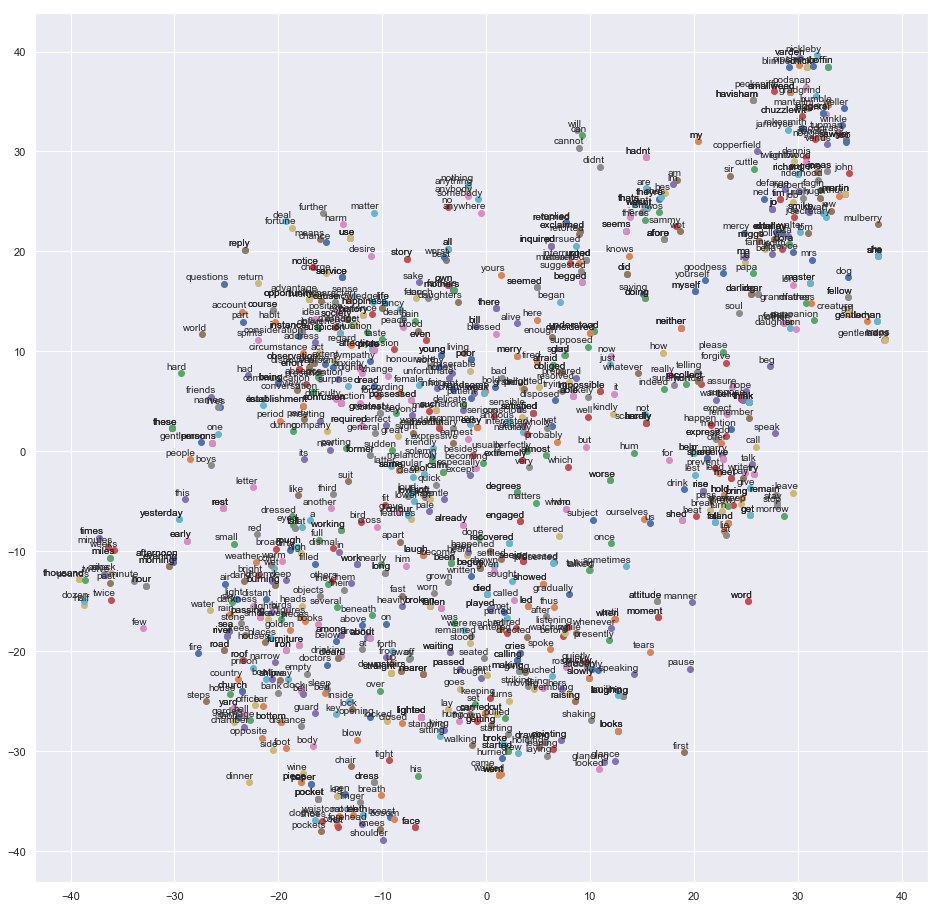

In [49]:
import random

plt.figure(figsize=(16, 16)) 
for j in range(1000):
    i = random.randint(0, len(coords))
    plt.scatter(coords.x[i],coords.y[i])
    plt.annotate(coords.label[i],
                 xy=(coords.x[i], coords.y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

## Visualization with Bokeh

In [51]:
import bokeh

In [61]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource
output_notebook()

source = ColumnDataSource(
        data=dict(
            x=coords.x,
            y=coords.y,
            label=coords.label,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("label", "@label"),
        ]
    )

p = figure(plot_width=800, plot_height=800, tools=[hover], title="Word Embedding of Dickens' Works")

p.circle('x', 'y', size=5, source=source)

show(p)

Loading BokehJS ...

# Interactive Visualization of Corpus - Dickens London Map

Some representative locations from Dickens' works are picked to make a map of London that shows where the stories happened.

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series

In [107]:
loc_collection = ['Holborn', 'Westminster', 'Pentonville', 'Smithfield', 'Lambeth', 'Leadenhall', 'Regent', 'Thames', 'Tottenham', 'Bishopsgate',
                 'Bloomsbury', 'Clerkenwell', 'Whitechapel', 'Grosvenor', 'Cheapside', 'Strand', 'Bedlam', 'Buckingham']

### Filter out chosen locations

In [108]:
Kt = K[K.token_str.isin(loc_collection)]
Kt.head()

pos    token_str  \
book                 chapter para_num sent_num token_num                     
A-Tale-of-Two-Cities 1       5        2        57         NNP  Westminster   
                     8       24       1        21         NNP       Bedlam   
                     12      1        1        44         NNP  Clerkenwell   
                     17      69       4        14         NNP       Thames   
Barnaby-Rudge        13      31       1        27         NNP       Thames   

                                                          punc  num  \
book                 chapter para_num sent_num token_num              
A-Tale-of-Two-Cities 1       5        2        57            0    0   
                     8       24       1        21            0    0   
                     12      1        1        44            0    0   
                     17      69       4        14            0    0   
Barnaby-Rudge        13      31       1        27            0    0   

                                                             term_str  term_id  
book                 chapter para_num sent_num token_num                        
A-Tale-of-Two-Cities 1       5        2        57         westminster    36542  
                     8       24       1        21              bedlam     2685  
                     12      1        1        44         clerkenwell     5731  
                     17      69       4        14              thames    32729  
Barnaby-Rudge        13      31       1        27              thames    32729

In [109]:
col = ['token_str']
Kt1 = pd.DataFrame(Kt,columns = col)
Kt1.head()

token_str
book                 chapter para_num sent_num token_num             
A-Tale-of-Two-Cities 1       5        2        57         Westminster
                     8       24       1        21              Bedlam
                     12      1        1        44         Clerkenwell
                     17      69       4        14              Thames
Barnaby-Rudge        13      31       1        27              Thames

### Count the frequency

In [110]:
v_counts = Kt1.apply(pd.value_counts)

In [111]:
v_counts

,token_str
Westminster,43
Thames,23
Holborn,19
Grosvenor,16
Buckingham,11
Clerkenwell,9
Leadenhall,8
Bloomsbury,8
Strand,8
Regent,7


### Load location information

In [234]:
locs = pd.read_csv('map_london.csv')

In [161]:
locs.head()

,location,latitude,longitude,count
0,Holborn,51.518382,-0.114415,19
1,Westminster,51.497422,-0.135599,43
2,Pentonville,51.530981,-0.110701,1
3,Smithfield,51.517767,-0.103477,5
4,Lambeth,51.493451,-0.117798,2


In [268]:
lat = np.array(locs["latitude"])                        # 获取维度之维度值
lon = np.array(locs["longitude"])                        # 获取经度值
count = np.array(locs["counter"],dtype=float)
name = list(locs['location'])

In [259]:
!conda install --yes --prefix {sys.prefix} folium==0.7.0 -c conda-forge

Solving environment: done

## Package Plan ##

  environment location: /Users/hanyuli/anaconda3

  added / updated specs:
    - folium==0.7.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.7.0               |             py_0          54 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          54 KB

The following packages will be DOWNGRADED:

  folium                                         0.8.3-py_0 --> 0.7.0-py_0



folium-0.7.0         | 54 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [350]:
import folium
import marker_cluster as mc

# Change colours
def color_change(c):
    if(c < 15):
        return('green')
    elif(15 <= c < 30):
        return('orange')
    else:
        return('red')

### Create a map of London

In [352]:
# Create base map
m = folium.Map(location = London,
                 zoom_start = 13, 
                 tiles = "CartoDB positron"
              )
#m_c = mc.MarkerCluster(locations=[lat, lon]).add_to(m)

# Plot markers
for point in range(len(lon)):
    folium.CircleMarker(location = [lat[point], lon[point]], 
                        radius = 9, 
                        popup = folium.Popup("("+str(count[point])+") "+name[point]),
                        fill_color = color_change(count[point]),
                        #fill = True,
                        color = "gray", 
                        fill_opacity = 0.5
                       ).add_to(m)
    
f = 'map_london_cluster.html'
m.save(f)
m